In [42]:
# TODO: Wrap this file into its own class and pipeline

In [1]:
from legacy.mouse import NeuroNN

J_array = [  0.6131,  -6.8548,   2.2939,  -5.6821]  # NES values
P_array = [-0.6996,  -7.7089,  -1.3388, -4.4278] 
w_array = [-12.3577, -15.2088,  -9.6759, -14.3590]

J_array = [-4.3900, -5.8650,  0.0000, -7.7800]  # NES init values
P_array = [-1.2200, -6.5920, -6.5920, -1.2200] 
w_array = [-12.2500, -12.2500, -12.2500, -12.2500]

model = NeuroNN(J_array, P_array, w_array, 10000, grad=False)
res = model()

finished all orientations and contrasts torch.Size([10000, 8, 12])


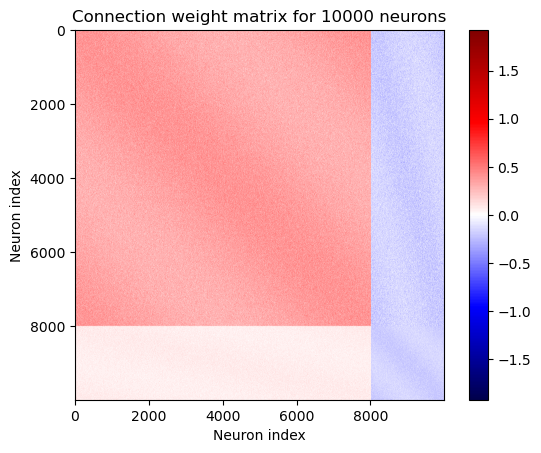

In [2]:
model = NeuroNN(J_array, P_array, w_array, 10000, grad=False, plot=True)

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

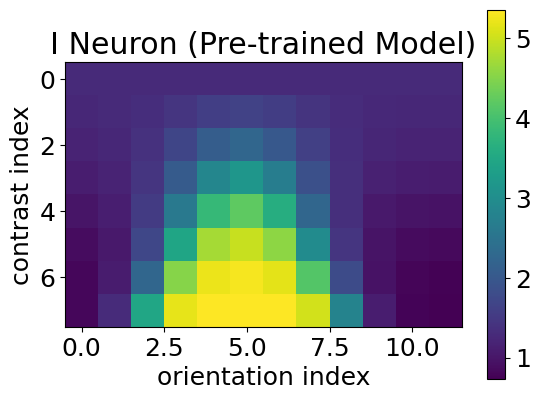

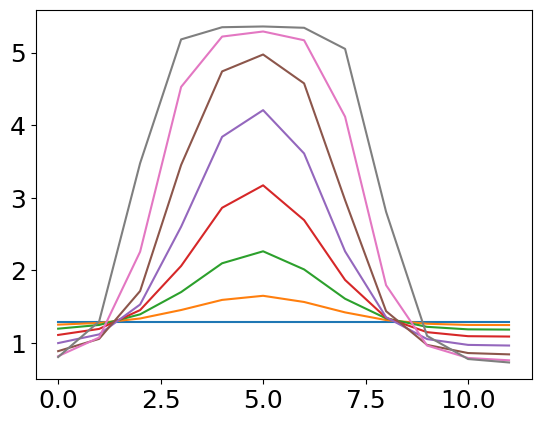

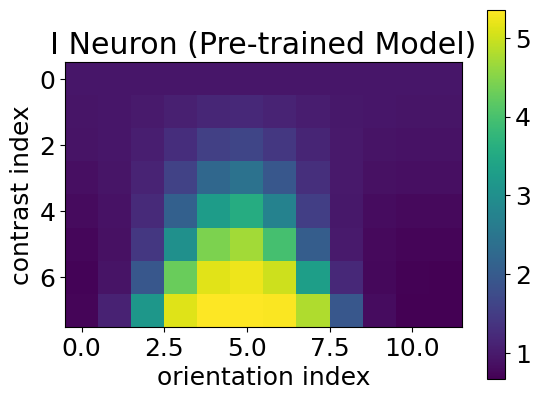

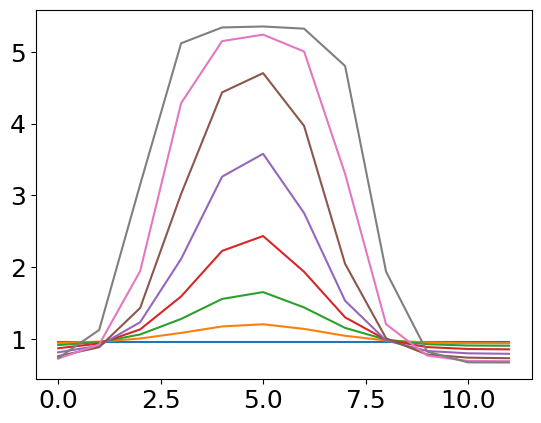

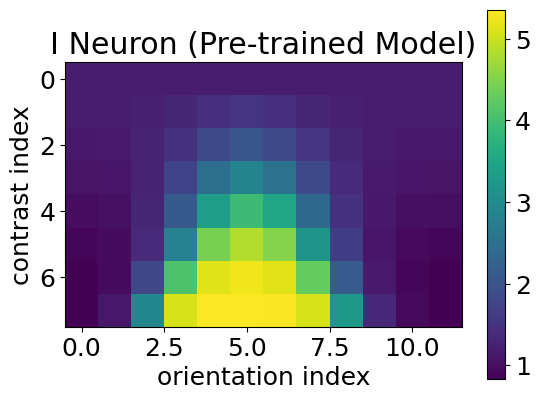

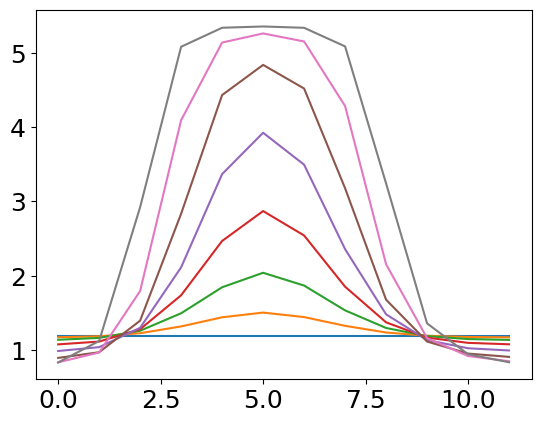

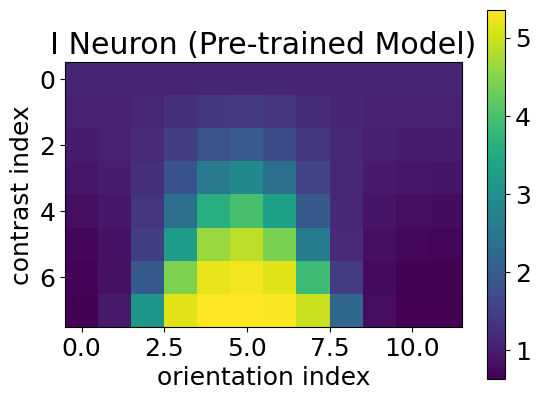

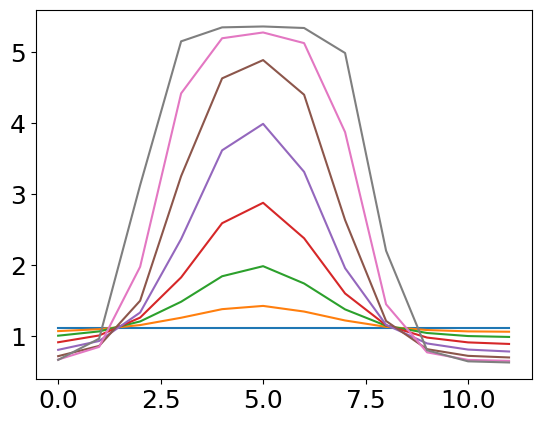

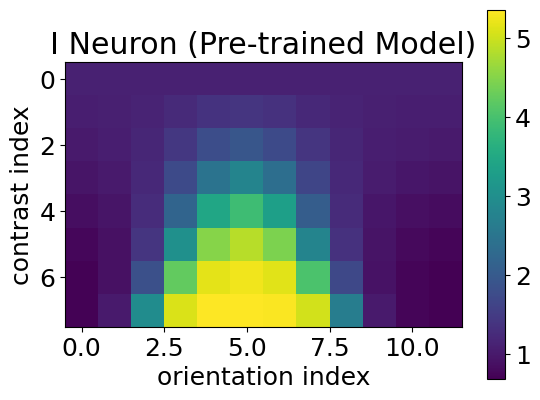

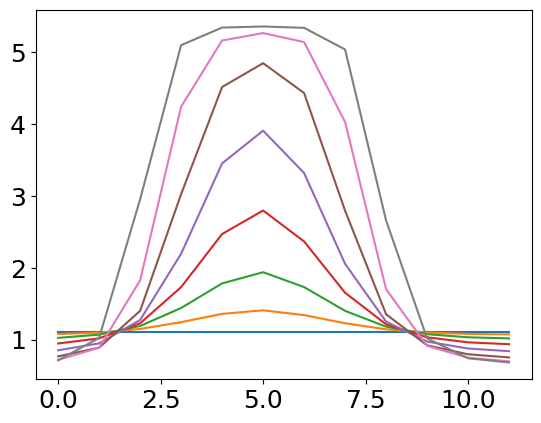

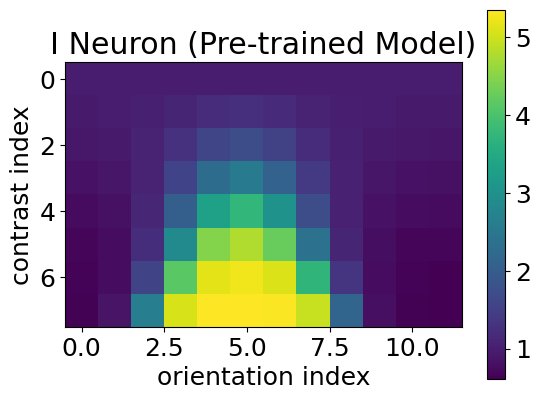

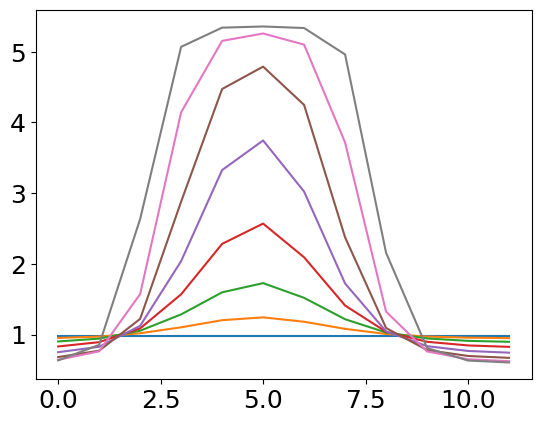

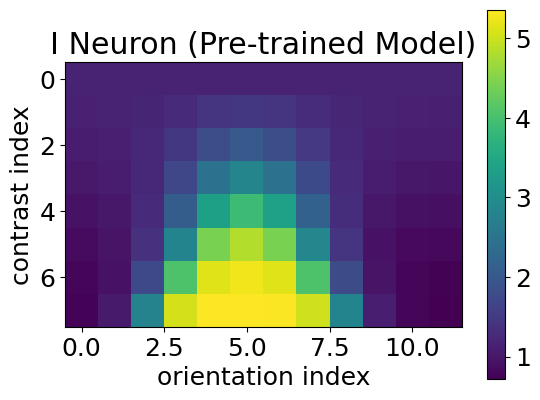

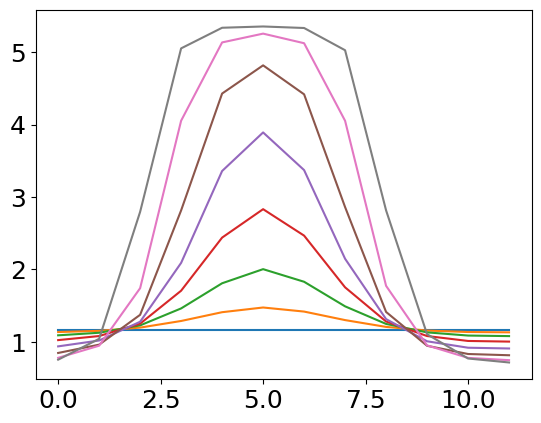

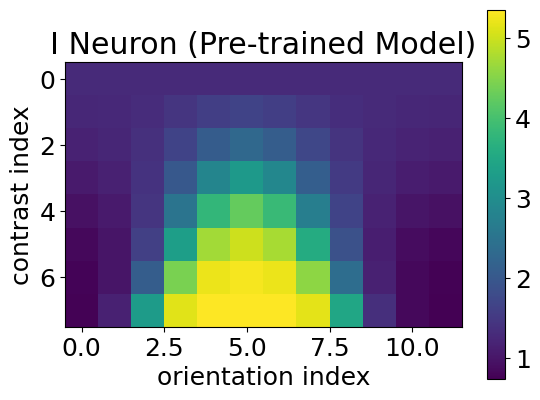

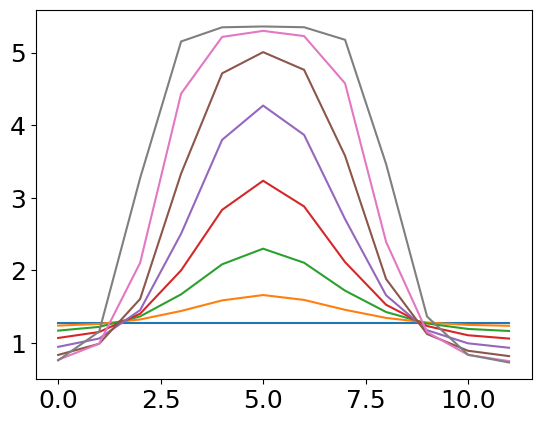

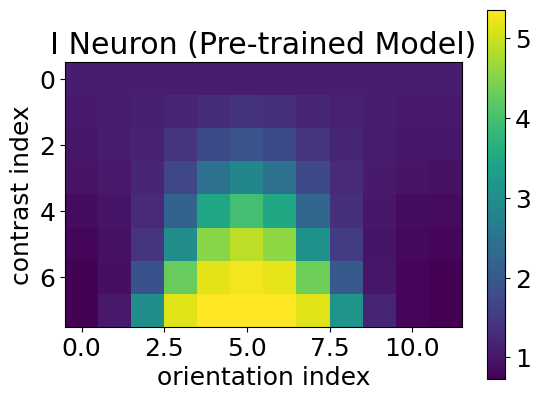

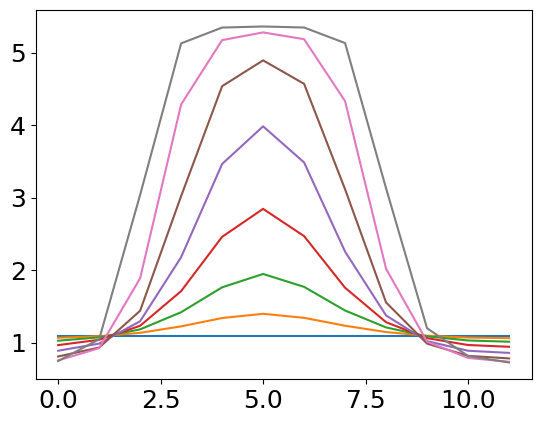

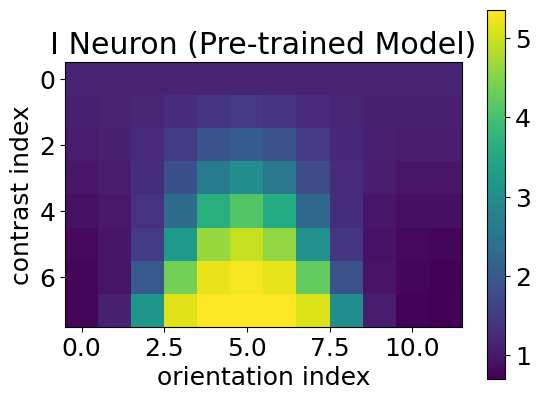

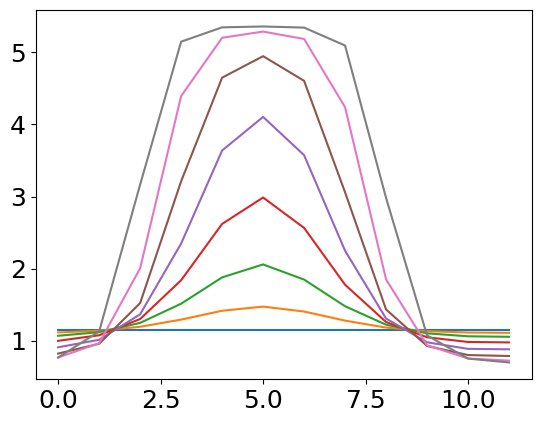

In [23]:
def print_tuning_curve(data_array: torch.Tensor, neuron_num):
    data_array = np.array(data_array.data)
    # tuncurv_orien_contr = np.mean(np.mean(data_array, axis=4), axis=3)

    some_neuron = data_array[neuron_num]

    plt.imshow(some_neuron, cmap='viridis')
    plt.colorbar()
    plt.title("I Neuron (Pre-trained Model)")
    plt.xlabel("orientation index")
    plt.ylabel("contrast index")
    plt.show()

    for c in some_neuron:
        plt.plot(c)

    plt.show()

for i in range(8820,8830):
    print_tuning_curve(res[0], i)

In [6]:
# Perform SVD
data_array = np.array(res[0].data)
some_neuron = data_array[9021]
U, S, Vt = np.linalg.svd(some_neuron)
k = 2 # number of singular values to keep
U_k = U[:, :k]
S_k = np.diag(S[:k])
Vt_k = Vt[:k, :]
reduced_neuron = np.dot(U_k, np.dot(S_k, Vt_k))

residue = some_neuron - reduced_neuron

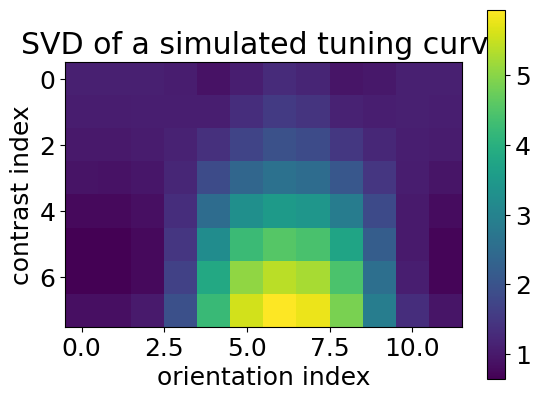

In [7]:
plt.imshow(reduced_neuron, cmap='viridis')
plt.colorbar()
plt.title("SVD of a simulated tuning curve")
plt.xlabel("orientation index")
plt.ylabel("contrast index")
plt.show()

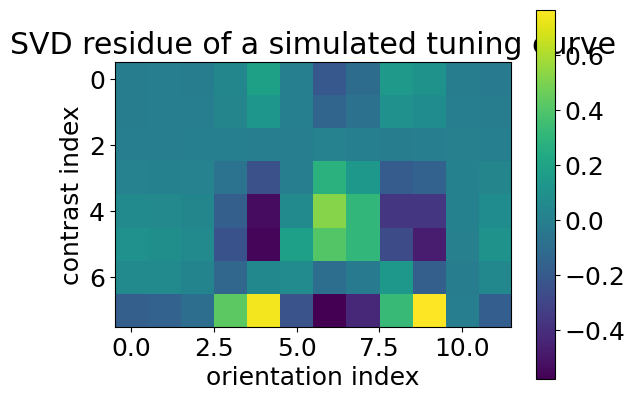

In [8]:
plt.imshow(residue, cmap='viridis')
plt.colorbar()
plt.title("SVD residue of a simulated tuning curve")
plt.xlabel("orientation index")
plt.ylabel("contrast index")
plt.show()

In [9]:
one_res = []
for i in range(10000):
    one_res.append(res[0][i][7][4])

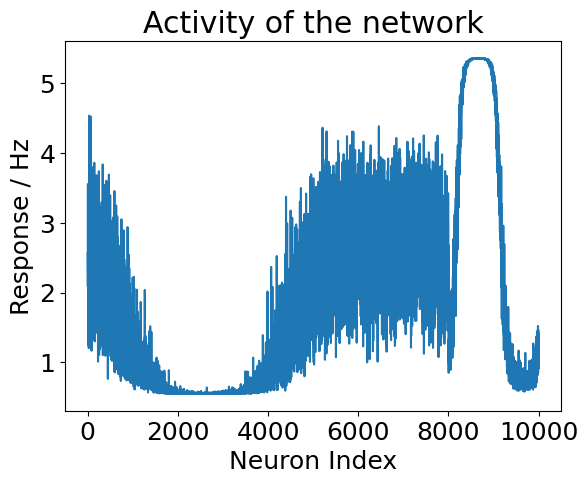

In [10]:
plt.plot(one_res)
plt.title("Activity of the network")
plt.xlabel("Neuron Index")
plt.ylabel("Response / Hz")
plt.show()

In [2]:
import pickle

# with open('response.pkl', 'wb') as f:
#     pickle.dump(res[0].data.tolist(), f)


# Contrast  - via Gaussian Fitting

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib

from scipy.optimize import curve_fit
import time
from scipy.stats import linregress
from tqdm import tqdm


matplotlib.rcParams.update({'font.size': 12})

In [3]:
with open('response.pkl', 'rb') as f:
    responses = pickle.load(f)

responses = np.array(responses)
responses.shape

(10000, 8, 12)

In [14]:
from legacy.mouse_trainer_functions import get_data

data = get_data()

/Users/paopao_ch/Documents/projects/v1_modelling/Mouse-V1-Pytorch/mouse_trainer_functions.py:310: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/K-Data.csv")
186624it [00:04, 41642.10it/s]


In [15]:
neuron_index = 2017
high_contrast_index = 7
mid_contrast_index = 6
low_contrast_index = 5
x_data = np.arange(12, dtype=int)


def get_max_index(tuning_curve):
    max_index = np.argmax(tuning_curve[high_contrast_index])
    return max_index


def get_min_index(tuning_curve, contrast_index=high_contrast_index):
    min_index = np.argmin(tuning_curve[contrast_index])
    return min_index


def centralise_curve(neuron_index, responses):
    max_index = get_max_index(responses[neuron_index])
    shift_index = 6 - max_index
    new_tuning_curve = np.roll(responses[neuron_index], shift_index, axis=1)
    return new_tuning_curve


def normalise_curve(tuning_curve):
    max_index = get_max_index(tuning_curve)  # this should be 6 if curve is centralised
    new_curve = np.zeros(tuning_curve.shape)
    for i, sub_curve in enumerate(tuning_curve):
        min_index = get_min_index(tuning_curve, i)
        new_curve[i] = (sub_curve - sub_curve[min_index]) / max((sub_curve[max_index] - sub_curve[min_index]), 0.00001)
        # new_curve[i] = (sub_curve - min(sub_curve)) / max((max(sub_curve) - min(sub_curve)), 0.00001)
    return new_curve



def gaussian(x, mean, std_dev):
    return np.exp(-(x - mean)**2 / (2 * std_dev**2))

def fit_gaussian(tuning_curve):
    initial_guess = [6, 1]  # Initial guess for the parameters: amplitude, mean, std_dev
    params, _ = curve_fit(gaussian, x_data, tuning_curve[high_contrast_index], p0=initial_guess)
    _, std_dev_fit_high = params

    params, _ = curve_fit(gaussian, x_data, tuning_curve[mid_contrast_index], p0=initial_guess)
    _, std_dev_fit_mid = params

    params, _ = curve_fit(gaussian, x_data, tuning_curve[low_contrast_index], p0=initial_guess)
    _, std_dev_fit_low = params
    return std_dev_fit_high**2, std_dev_fit_mid**2, std_dev_fit_low**2


def get_contrast_inv_std(neuron_index, responses):
    new_tuning_curve = centralise_curve(neuron_index, responses)
    new_tuning_curve = normalise_curve(new_tuning_curve)
    # plt.imshow(new_tuning_curve)
    # plt.show()
    return fit_gaussian(new_tuning_curve)


def get_all_contrast_inv(responses):
    output = []
    failed_fit_count = 0
    # for i in tqdm(range(0,73)):
    for i in tqdm(range(0,8000)):
        try:
            high_std, mid_std, low_std = get_contrast_inv_std(i, responses)
            if high_std < 10 and mid_std < 10 and low_std < 10:
                output.append((high_std, mid_std, low_std))
            else:
                failed_fit_count += 1
        except:
            failed_fit_count += 1

    print(failed_fit_count)
    return output

contrast_inv = get_all_contrast_inv(responses)
contrast_inv = np.array(contrast_inv)


# get_contrast_inv_std(1000)



100%|██████████| 8000/8000 [00:06<00:00, 1243.91it/s]

3254


In [16]:
contrast_inv

array([[6.40231479, 4.25222355, 3.32582255],
       [1.62741591, 2.60411922, 3.03929048],
       [4.38593516, 5.51089551, 7.06157007],
       ...,
       [1.62252883, 1.73034606, 2.74300731],
       [6.6976676 , 6.16843906, 6.17444075],
       [3.76554944, 3.22435581, 3.51140051]])

0.3787572385681613


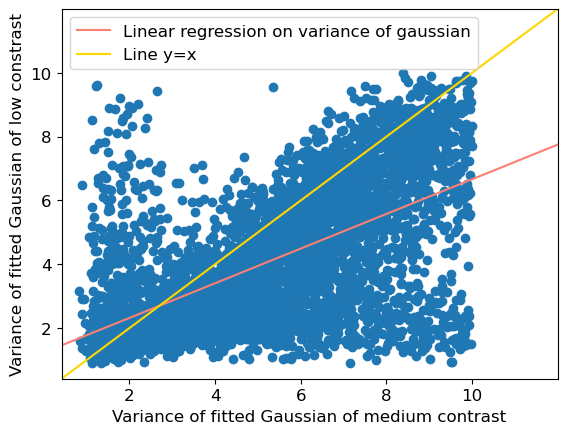

In [17]:
high = contrast_inv[:, 0]
mid = contrast_inv[:, 1]
low = contrast_inv[:, 2]


def get_r2(array1, array2):
    slope, intercept, r_value, p_value, std_err = linregress(array1, array2)
    return slope, intercept, r_value**2


def plot_cont_inv(array1, array2):
    slope, intercept, r2_value = get_r2(array1, array2)
    print(r2_value)
    x = np.arange(0, max(max(array1), max(array2)) * 1.2 + 1, 1)
    y = slope * x + intercept
    plt.xlim(min(min(array1), min(array2)) * 0.5, max(max(array1), max(array2)) * 1.2)
    plt.ylim(min(min(array1), min(array2)) * 0.5, max(max(array1), max(array2)) * 1.2)
    plt.scatter(array1, array2)
    plt.plot(x, y, color="salmon", label="Linear regression on variance of gaussian")
    plt.plot(x, x, color="gold", label="Line y=x")
    plt.xlabel("Variance of fitted Gaussian of medium contrast")
    plt.ylabel("Variance of fitted Gaussian of low constrast")
    plt.legend()
    plt.show()

plot_cont_inv(high, mid)

# Contrast Invariance - via SVD

In [18]:
def neuro_SVD(tuning_curves):
    U, S, Vt = np.linalg.svd(tuning_curves)
    k = 1 # number of singular values to keep
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    Vt_k = Vt[:k, :]
    reduced_neuron = np.dot(U_k, np.dot(S_k, Vt_k))

    residue = some_neuron - reduced_neuron
    return reduced_neuron, residue, S

In [19]:

def get_all_percentage_explained(responses):
    percentages = []
    for tuning_curve in responses:
        _, residue, S = neuro_SVD(tuning_curve)
        percentage_explained = (np.sum(residue)**2) / (np.sum(tuning_curve)**2)
        percentages.append(percentage_explained)
    return percentages


def get_all_fraction_of_variance(responses):
    frac_of_vars = []
    for tuning_curve in responses:
        _, _, S = neuro_SVD(tuning_curve)
        # frac_of_var = (np.linalg.norm(S[1:]) ** 2) / (np.linalg.norm(S) ** 2)
        frac_of_var = (np.linalg.norm(S[0]) ** 2) / (np.linalg.norm(S) ** 2)
        frac_of_vars.append(frac_of_var)
    return frac_of_vars

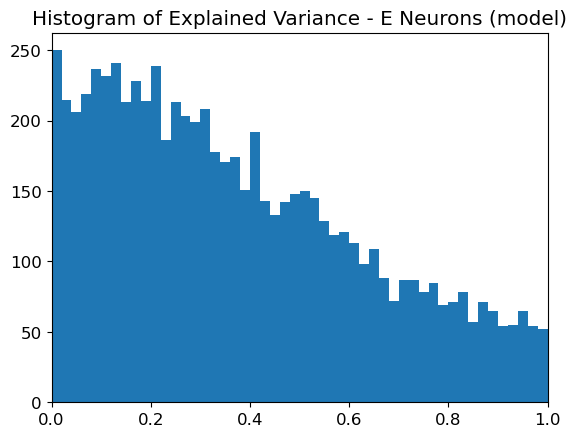

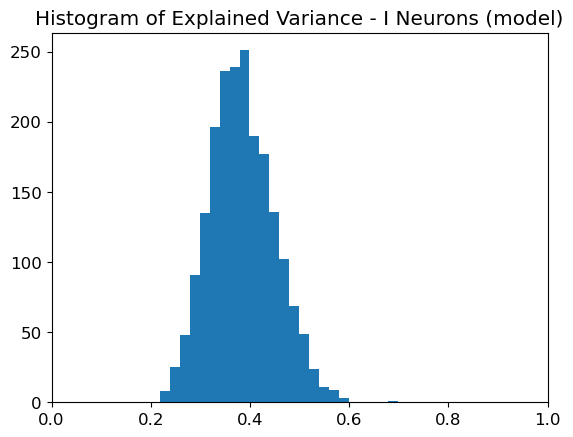

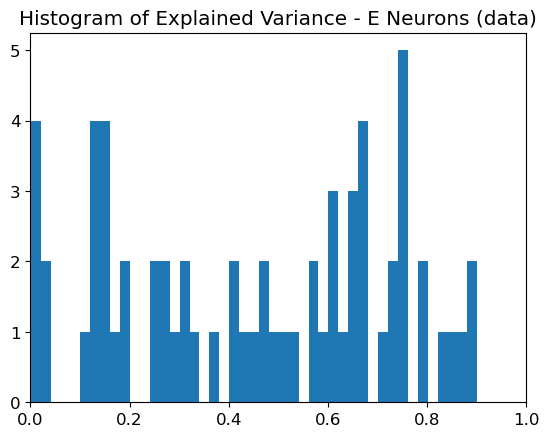

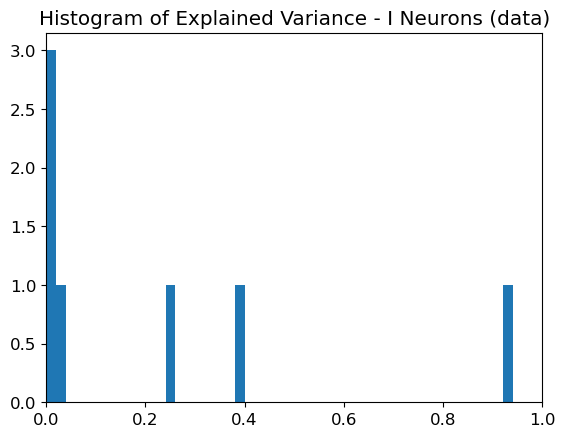

In [20]:
bin_size = 0.02

def plot_percentage_explained(tuning_curves, title=""):
    percentages = get_all_percentage_explained(tuning_curves)
    bins = np.arange(min(percentages), max(percentages) + bin_size, bin_size)
    plt.xlim(0, 1)
    plt.hist(percentages, bins)
    plt.title(title)
    plt.show()


plot_percentage_explained(responses[:8000], "Histogram of Explained Variance - E Neurons (model)")
plot_percentage_explained(responses[8000:], "Histogram of Explained Variance - I Neurons (model)")
plot_percentage_explained(np.array(data[:73].data), "Histogram of Explained Variance - E Neurons (data)")
plot_percentage_explained(np.array(data[73:]), "Histogram of Explained Variance - I Neurons (data)")

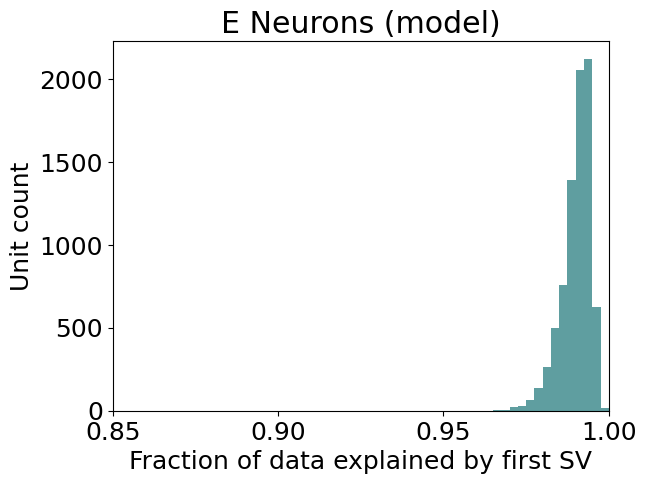

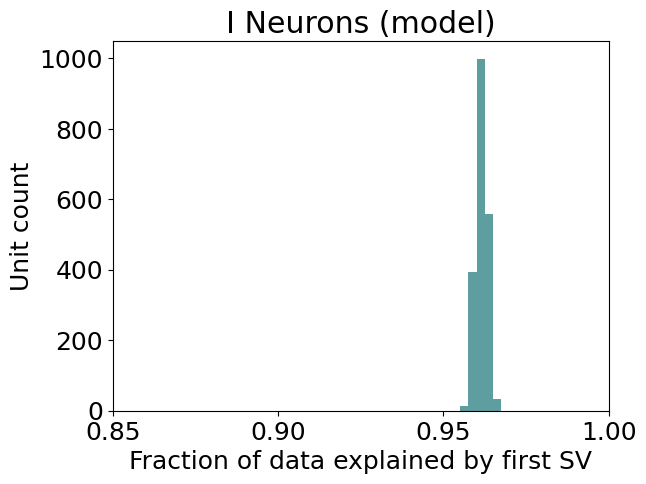

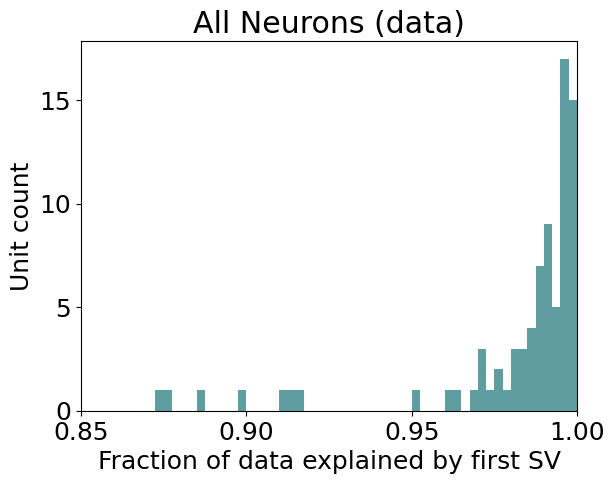

In [21]:
bin_size = 0.0025

def plot_frac_of_var(tuning_curves, title=""):
    frac_of_vars = get_all_fraction_of_variance(tuning_curves)
    bins = np.arange(0, 1 + bin_size, bin_size)
    plt.hist(frac_of_vars, bins, bottom=0, width=bin_size, color="cadetblue")
    plt.xticks(np.arange(0, 1 + bin_size, bin_size * 20))
    plt.xlim(0.85, 1)
    plt.title(title)
    plt.xlabel("Fraction of data explained by first SV")
    plt.ylabel("Unit count")
    plt.show()

matplotlib.rcParams.update({'font.size': 18})
plot_frac_of_var(responses[:8000], "E Neurons (model)")
plot_frac_of_var(responses[8000:], "I Neurons (model)")
plot_frac_of_var(np.array(data), "All Neurons (data)")

# Single Statistic (histogram) plots

### Circular Variance

In [4]:
from scipy.stats import circvar

In [5]:
def get_circ_var(tuning_curve, contrast_index=7):
    tc_1D = tuning_curve[contrast_index]
    return circvar(tc_1D)

In [33]:
def plot_hist(func, contrast_index=7, title="", bin_size=None, bin_num=10, ranges=[0,8000]):
    circ_vars = []

    for i in range(*ranges):
        circ_vars.append(func(responses[i], contrast_index))

    if bin_size is not None:
        bins = np.arange(min(circ_vars), max(circ_vars) + bin_size, bin_size)
        plt.hist(circ_vars, bins)
    else:
        plt.hist(circ_vars, bin_num)
        
    plt.title(title)
    plt.show()

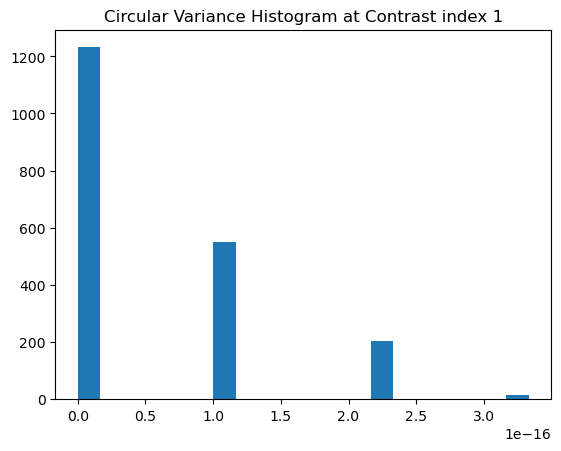

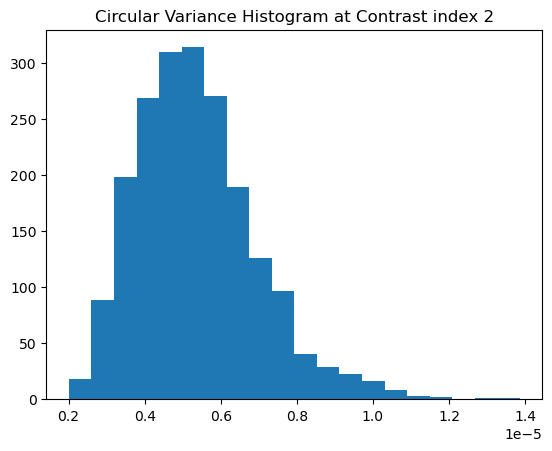

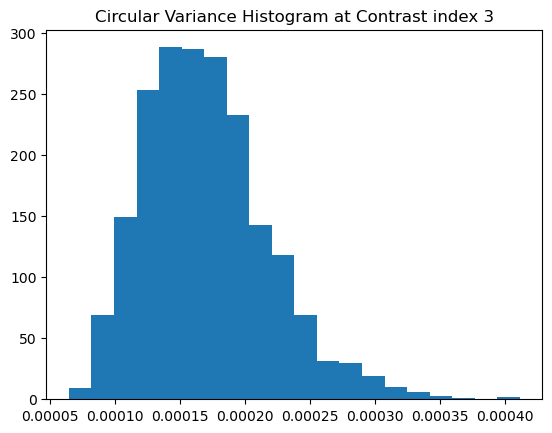

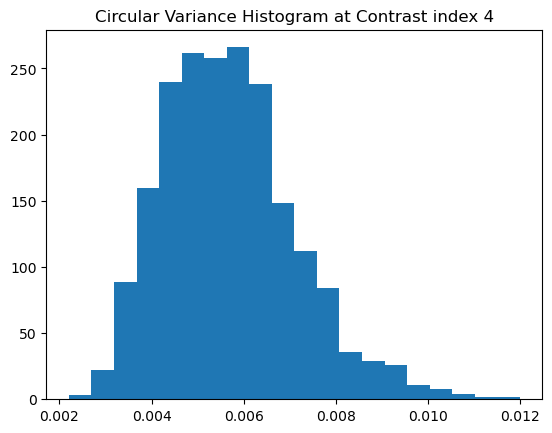

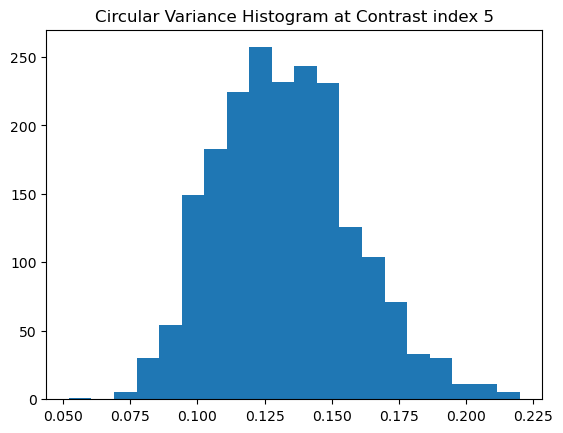

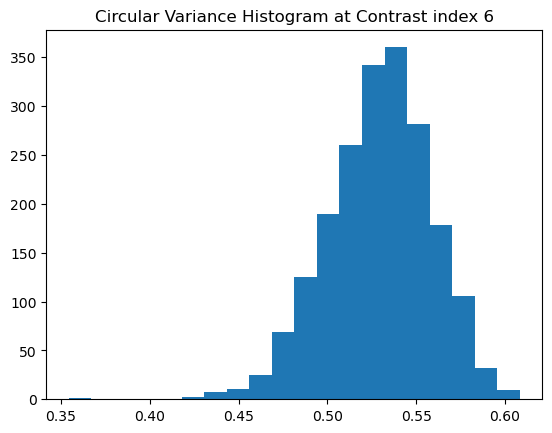

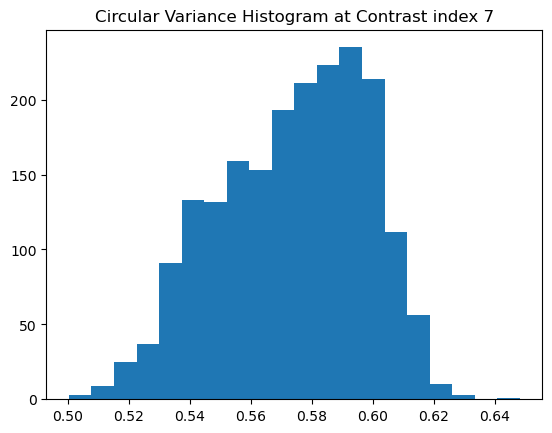

In [40]:
for i in range(7):
    plot_hist(get_circ_var, i, f"Circular Variance Histogram at Contrast index {i + 1}", bin_num=20, ranges=[8000, 10000])

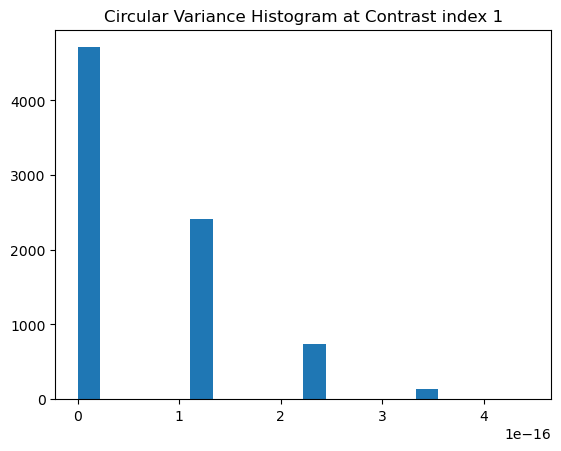

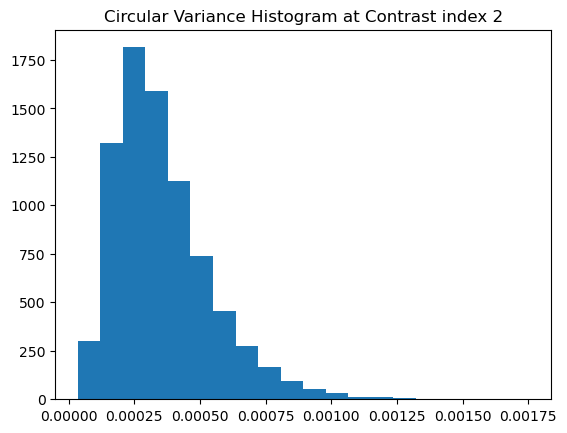

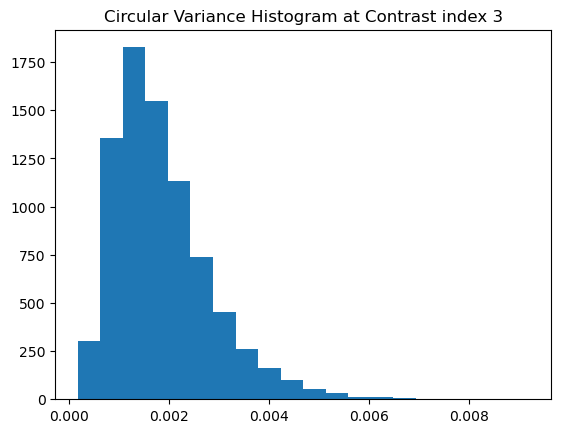

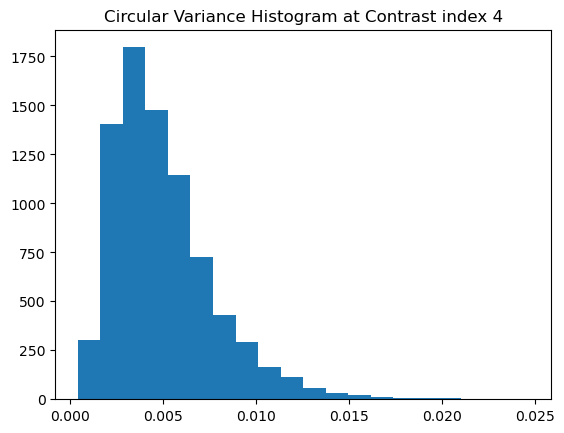

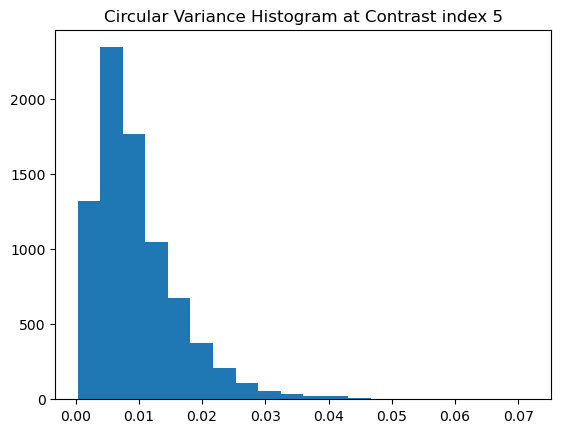

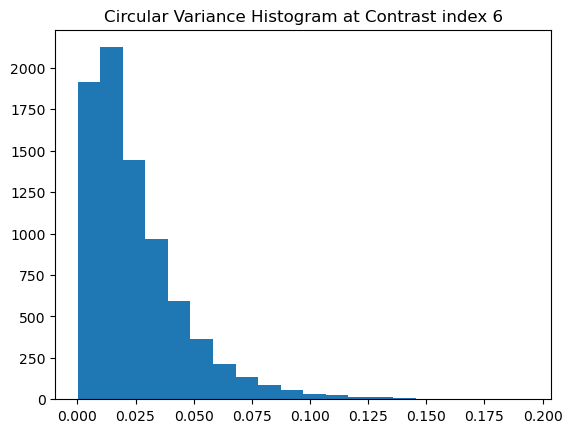

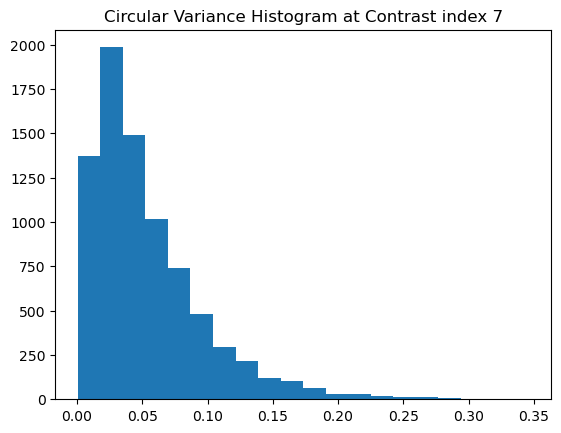

In [41]:
for i in range(7):
    plot_hist(get_circ_var, i, f"Circular Variance Histogram at Contrast index {i + 1}", bin_num=20, ranges=[0, 8000])

### Max firing rate

In [13]:
def get_max_firing_rate(tuning_curve, contrast_index=7):
    return np.max(tuning_curve)

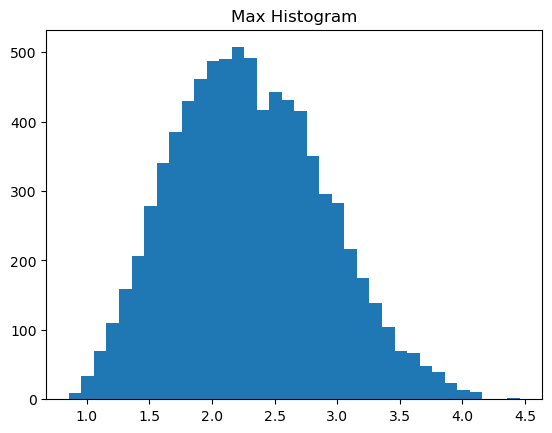

In [39]:
plot_hist(get_max_firing_rate, 0, f"Max Histogram", 0.1)

### Mean firing rate

In [16]:
def get_mean_firing_rate(tuning_curve, contrast_index=7):
    return np.mean(tuning_curve)

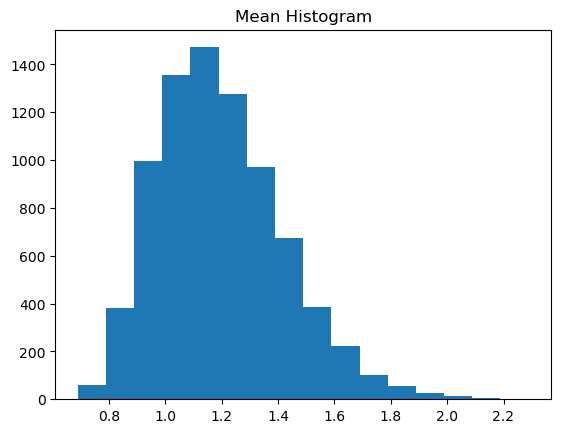

In [38]:
plot_hist(get_mean_firing_rate, 0, f"Mean Histogram", 0.1)

# Balance of excitation and inhibition